In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.ticker import FuncFormatter
import scipy.optimize as op
import scipy.stats as st
from preprocessing import *
plt.style.use("dark_background") # Config plots for dark mode, delete if on light mode
plt.rcParams['figure.dpi'] = 150 # Hi-res plots

In [2]:
def N(t_scalar, t):
    """
    Returns the number of times in t less than or equal to t_scalar.
    Is used to compute N(t_{i,k}) and N'(t_{i,k}) depending on whether t above is t or t_prime
    """
    return np.searchsorted(t, t_scalar, side="right")

def get_time_differences(t, t_prime):
    """
    Input: (sorted) times for a particular station i
    Output: List of differences indexed by [h][k] for this station i
    """

    # h goes until N(t[-1], t)
    T = end_T
    differences = []
    for h in range(N(T, t)):
        differences_list = []
        # Construct list of t_ih - t'_ik for k = 1 to N'(T)
        differences_list.append(t[h] - t_prime[N(t[h-1], t_prime):N(t[h], t_prime)])

        differences.append(np.asarray(differences_list))

    return differences

def m4_compensator_helper(t_scalar, t, t_prime):
    """
    Computes the lists that are required for the compensator function outside of it (without the parameters)
    """
    t_difference = t_scalar - t[:N(t_scalar, t)]
    t_prime_difference = t_scalar - t_prime[:N(t_scalar, t_prime)]
    return t_difference, t_prime_difference

In [3]:
# def get_time_differences_2(t, t_prime):
#     """
#     Input: (sorted) times for a particular station i
#     Output: List of differences indexed by [h][k] for this station i
#     """

#     # h goes until N(t[-1], t)
#     T = end_T
#     differences = np.array([])
#     for h in range(N(T, t)):
#         differences_list = []
#         # Construct list of t_ih - t'_ik for k = 1 to N'(T)
#         differences_list.append(t[h] - t_prime[N(t[h-1], t_prime):N(t[h], t_prime)])

#         differences = np.append(differences, np.asarray(differences_list))

#     return differences

In [4]:
# def compensator_m4(t_scalar, t, t_prime, alpha_i, beta_i, alpha_i_prime, beta_i_prime,lambda_i):
#     """
#     t_scalar: scalar value where Lambda_i(t) is to be evaluated
#     t_prime: list of arrival times at station i

#     NOTE: t_prime NEEDS TO BE SORTED HERE.
#     """

#     term1 = lambda_i * t_scalar
#     term2 = -(alpha_i_prime / beta_i_prime) * np.sum(np.exp(-beta_i_prime * (t_scalar - t_prime[:N(t_scalar, t_prime)]))-1)
#     term3 = -(alpha_i / beta_i) * np.sum(np.exp(-beta_i * (t_scalar - t[:N(t_scalar, t)]))-1)
#     return term1 + term2 + term3


In [5]:
def B_m4(h, t, t_prime, beta, time_differences):

    """
    Returns a list of [B_i(1), ..., B_i(h)]

    NOTE: t_prime NEEDS to be sorted here

    time_differences: time differences double list for station i

    Note all index variables such as h, k, etc start at 1, like the mathematical notation.
    """
    B = [np.sum(np.exp(-beta*(t[0] - t_prime[:N(t[0], t_prime)])))]

    # Append the rest
    for l in range(1, h):
        # First term in recursive formula for B_i(h)
        term1 = np.exp(-beta*(t[l] - t[l-1])) * B[l-1]
        term2 = np.sum(np.exp(-beta*(time_differences[l])))
        B.append(term1 + term2)
    return np.array(B)


def A_m4(h, t, beta):
    A = [0]
    for j in range(1, h):
            A.append(np.exp(-beta*(t[j] - t[j-1]))*(1+A[j-1]))
    return np.asarray(A)
import numpy as np


# def m4_log_likelihood(t, t_prime, time_differences, alpha_i, beta_i, alpha_i_prime, beta_i_prime, lambda_i):
#     """
#     Gives log likelihood of our five parameters. 
#     t: start times from station i
#     t_prime: end times at station i

#     NOTE: t_prime NEEDS TO BE SORTED HERE
#     """
    
#     T = end_T # TODO: Is this how we get big T?

#     # Get A list
#     A_ = new_A(len(t), t, beta_i)

#     # Get B list 
#     B_ = new_B(len(t), t, t_prime, beta_i_prime, time_differences)

#     term1 = np.sum(np.log(lambda_i + alpha_i_prime*B_[:len(t)+1] + alpha_i*A_[:len(t)+1]))

#     term2 = -compensator_m4(T, t, t_prime, alpha_i, beta_i, alpha_i_prime, beta_i_prime, lambda_i)

#     return term1 + term2


In [6]:
def compensator_m4(t_scalar, t_precomputed, t_prime_precomputed, lambda_i, alpha_i, alpha_i_prime, beta_i, beta_i_prime):
    """
    Evaluates compensator using already pre-computed list terms so we don't compute it every time.
    """
    term1 = lambda_i * t_scalar
    term2 = -(alpha_i_prime / beta_i_prime) * np.sum(np.exp(-beta_i_prime * (t_prime_precomputed))-1)
    term3 = -(alpha_i / beta_i) * np.sum(np.exp(-beta_i * (t_precomputed))-1)
    return term1 + term2 + term3

def m4_log_likelihood(t_params,
 lambda_i, alpha_i, alpha_i_prime, beta_i, beta_i_prime):
    """
    Gives log likelihood of our five parameters. 
    t: start times from station i
    t_prime: end times at station i

    NOTE: t_prime NEEDS TO BE SORTED HERE
    """
    # t_params: t, trunc_t, tprime, trunc_tprime, time_diffs
    t, t_precomputed, t_prime, t_prime_precomputed, time_differences = t_params
    length_t = N(end_T, t)
    T = end_T
    A_ = A_m4(length_t, t, beta_i)
    B_ = B_m4(length_t, t, t_prime, beta_i_prime, time_differences)
    term1 = np.sum(np.log(lambda_i + alpha_i*A_ + alpha_i_prime*B_))
    term2 = -compensator_m4(T, t_precomputed, t_prime_precomputed, lambda_i, alpha_i, alpha_i_prime,beta_i, beta_i_prime)

    return term1 + term2

In [7]:
time_diffs = {}
for st_id in tqdm(train_sorted_start_ids):
    time_diffs[st_id] = get_time_differences(t_per_station[st_id], t_prime_per_station[st_id])

100%|██████████| 789/789 [00:13<00:00, 58.28it/s]


In [8]:
trunc_t_per_station = {}
for st_id in tqdm(train_sorted_start_ids):
    t = t_per_station[st_id]
    t_prime = t_prime_per_station[st_id]
    trunc_t_per_station[st_id] = m4_compensator_helper(end_T, t, t_prime)[0]
trunc_t_prime_per_station = {}
for st_id in tqdm(train_sorted_start_ids):
    t = t_per_station[st_id]
    t_prime = t_prime_per_station[st_id]
    trunc_t_prime_per_station[st_id] = m4_compensator_helper(end_T, t, t_prime)[1]

100%|██████████| 789/789 [00:00<00:00, 58717.28it/s]


In [9]:
# combine to new dict called station parameters: ordered as t, trunc_t, tprime, trunc_tprime, time_diffs
station_time_parameters = {}
for st_id in tqdm(train_sorted_start_ids):
    station_time_parameters[st_id] = [t_per_station[st_id], trunc_t_per_station[st_id], t_prime_per_station[st_id], trunc_t_prime_per_station[st_id], time_diffs[st_id]]

100%|██████████| 789/789 [00:00<00:00, 1349085.14it/s]


## Finding the parameters using likelihood optimisation

In [10]:
model_2_params = pd.read_csv("../data/parameters/M2_train_params.csv", index_col=0)
model_3_params = pd.read_csv("../data/parameters/M3_train_params.csv", index_col=0)
model_3_params

,alpha,beta,lambda
1,0.020179,0.035553,7.705058e-03
2,0.015271,0.016036,1.213006e-03
3,0.004644,0.004644,3.779973e-17
4,0.009820,0.023543,9.676464e-03
5,0.011876,0.012869,1.258996e-03
...,...,...,...
836,0.014502,0.039605,1.707352e-02
838,0.006228,0.006470,4.663218e-04
839,0.023140,0.028994,8.233945e-03
840,0.018468,0.019006,2.030979e-04


In [18]:
unconverged_it1 = []
N_stat = len(train_sorted_start_ids)+1
optimal_parameters_it1 = {}
for st_id in tqdm(train_sorted_start_ids[:N_stat]):
    # m2_station_params = model_2_params.loc[st_id].to_numpy()
    # m3_station_params = model_3_params.loc[st_id].to_numpy()
    #x0 = [np.log(m2_station_params[0]), np.log(m2_station_params[1] -m2_station_params[0] ), np.log(m3_station_params[0]), np.log(m3_station_params[1] - m3_station_params[0]), np.log(m3_station_params[-1])] # np.log(rates_dict[station.start_id.unique()[0]])]
    x0 = -np.ones(5) * 3
    op_m4_log_likelihood = lambda x: -m4_log_likelihood(station_time_parameters[st_id], np.exp(x[0]), np.exp(x[1]), np.exp(x[2]), np.exp(x[1]) + np.exp(x[3]), np.exp(x[2]) + np.exp(x[4]))
    sol = op.minimize(op_m4_log_likelihood, x0, method="Nelder-Mead")
    if sol.success:
        transformed_lambda = np.exp(sol.x[0])
        transformed_alpha = np.exp(sol.x[1])
        transformed_alpha_prime = np.exp(sol.x[2])
        transformed_beta = np.exp(sol.x[1]) + np.exp(sol.x[3])
        transformed_beta_prime = np.exp(sol.x[2]) + np.exp(sol.x[4])
        max_params = [transformed_lambda, transformed_alpha, transformed_alpha_prime, transformed_beta, transformed_beta_prime]
        optimal_parameters_it1[st_id] = max_params

    else:
        unconverged_it1.append(st_id)
        print(f"{st_id} failed to converge.")

  6%|▋         | 51/789 [06:07<1:25:13,  6.93s/it]

53 failed to converge.


 32%|███▏      | 253/789 [37:10<1:15:55,  8.50s/it]

263 failed to converge.


 40%|████      | 319/789 [1:59:13<1:58:58, 15.19s/it]   

332 failed to converge.


 42%|████▏     | 333/789 [2:01:33<1:44:52, 13.80s/it]

348 failed to converge.


 46%|████▋     | 365/789 [2:05:39<50:05,  7.09s/it]  

382 failed to converge.


 47%|████▋     | 373/789 [2:06:57<54:49,  7.91s/it]  

391 failed to converge.


 63%|██████▎   | 494/789 [2:21:01<31:49,  6.47s/it]  

528 failed to converge.


 70%|███████   | 554/789 [2:28:28<21:47,  5.56s/it]

594 failed to converge.


100%|██████████| 789/789 [2:57:59<00:00, 13.54s/it]


In [20]:
unconverged_it2 = []
optimal_parameters_it2 = {}
for st_id in tqdm(unconverged_it1):
    # m2_station_params = model_2_params.loc[st_id].to_numpy()
    # m3_station_params = model_3_params.loc[st_id].to_numpy()
    #x0 = [np.log(m2_station_params[0]), np.log(m2_station_params[1] -m2_station_params[0] ), np.log(m3_station_params[0]), np.log(m3_station_params[1] - m3_station_params[0]), np.log(m3_station_params[-1])] # np.log(rates_dict[station.start_id.unique()[0]])]
    x0 = -np.ones(5) * 5
    op_m4_log_likelihood = lambda x: -m4_log_likelihood(station_time_parameters[st_id], np.exp(x[0]), np.exp(x[1]), np.exp(x[2]), np.exp(x[1]) + np.exp(x[3]), np.exp(x[2]) + np.exp(x[4]))
    sol = op.minimize(op_m4_log_likelihood, x0, method="Nelder-Mead")
    if sol.success:
        transformed_lambda = np.exp(sol.x[0])
        transformed_alpha = np.exp(sol.x[1])
        transformed_alpha_prime = np.exp(sol.x[2])
        transformed_beta = np.exp(sol.x[1]) + np.exp(sol.x[3])
        transformed_beta_prime = np.exp(sol.x[2]) + np.exp(sol.x[4])
        max_params = [transformed_lambda, transformed_alpha, transformed_alpha_prime, transformed_beta, transformed_beta_prime]
        optimal_parameters_it1[st_id] = max_params

    else:
        unconverged_it2.append(st_id)
        print(f"{st_id} failed to converge.")

100%|██████████| 8/8 [01:11<00:00,  8.97s/it]


789

In [11]:
m4_parameters = pd.read_csv("../data/parameters/M4_train_params.csv", index_col=0)
m4_parameters

,lambda,alpha,alpha_prime,beta,beta_prime
1,4.289390e-03,0.013056,0.017923,0.031378,0.051294
2,9.572699e-04,0.185765,0.012679,1.004565,0.016323
3,4.247778e-05,0.039154,0.003156,0.099732,0.005210
4,7.389633e-03,0.229210,0.007624,1.002632,0.023494
5,1.122830e-03,0.135349,0.009782,0.695608,0.013202
...,...,...,...,...,...
348,4.788027e-16,0.180440,0.007293,0.649903,0.010667
382,8.784522e-16,0.056997,0.002474,0.133069,0.004793
391,2.377948e-16,0.043655,0.001641,0.070177,0.004700
528,3.731134e-16,0.069921,0.002179,0.158773,0.004028


## Assessing fit for model 4

In [12]:
# m4_param_df = pd.DataFrame(optimal_parameters.values(), index=optimal_parameters.keys(), columns = ["alpha", "beta", "alpha_prime", "beta_prime", "lambda"])
# m4_param_df.head() 
# m4_param_df.to_csv("../data/parameters/M4_train_params.csv")

In [13]:
test_precomputed_t_dict = {}
test_precomputed_t_prime_dict = {}
for st_id in tqdm(train_sorted_start_ids):
    tprime = test_t_prime_per_station[st_id]
    time = test_t_per_station[st_id]
    precomputed_t_lambda = lambda x: m4_compensator_helper(x, time, tprime)[0]
    precomputed_t_prime_lambda = lambda x: m4_compensator_helper(x, time, tprime)[1]
    test_precomputed_t_dict[st_id] = np.asarray([precomputed_t_lambda(t) for t in time], dtype=object)
    test_precomputed_t_prime_dict[st_id] = np.asarray([precomputed_t_prime_lambda(t) for t in time], dtype=object)

100%|██████████| 789/789 [00:09<00:00, 81.15it/s] 


In [14]:
compensated_times_dict = {}
for st_id in tqdm(train_sorted_start_ids):
    params = m4_parameters.loc[st_id].to_numpy()
    tprime = test_t_prime_per_station[st_id]
    time = test_t_per_station[st_id]
    comp_st = lambda x: compensator_m4(x, m4_compensator_helper(x, time, tprime)[0],m4_compensator_helper(x, time, tprime)[1] , params[0], params[1], params[2], params[3], params[4])
    compensated_times_dict[st_id] = [comp_st(t) for t in time]

100%|██████████| 789/789 [00:18<00:00, 43.68it/s]


In [15]:
m4_p_values = {}

for st_id in tqdm(test_sorted_start_ids):
    inter_arrival_times = np.diff(compensated_times_dict[st_id])
    inter_arrival_times = np.insert(inter_arrival_times,0,compensated_times_dict[st_id][0])
    station_p_values = np.exp(-inter_arrival_times)
    m4_p_values[st_id] = station_p_values

100%|██████████| 788/788 [00:00<00:00, 22124.94it/s]


In [16]:
m4_p_values_df = pd.DataFrame(m4_p_values.values(), m4_p_values.keys())
m4_p_values_df.to_csv("../data/p_values/M4_p_values.csv")

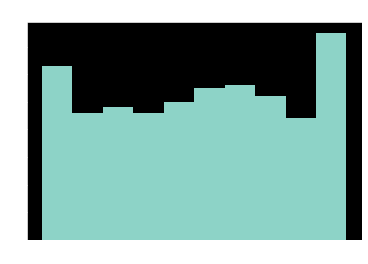

In [17]:
plt.title("Histogram of p-values for station 1 using Model 4")
plt.hist(m4_p_values[1])
plt.show()

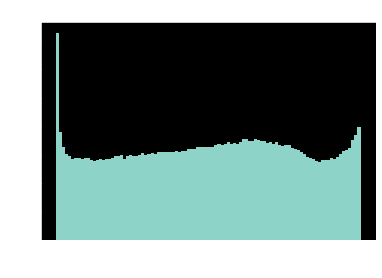

In [18]:
joined_p_values = np.concatenate(np.asarray(list(m4_p_values.values()), dtype=object))
n, bins, patches = plt.hist(joined_p_values, bins=100)
ax = plt.gca()
def lblFormat(n, pos):
    return str(int(n / 1e3))
lblFormatter = FuncFormatter(lblFormat)
ax.yaxis.set_major_formatter(lblFormatter)
plt.title("Histogram of p-values for all stations for Model 4")
plt.xlabel("P-value")
plt.ylabel("Counts (Thousands)")
plt.savefig("../figures/p-values_m3.png")
plt.show()

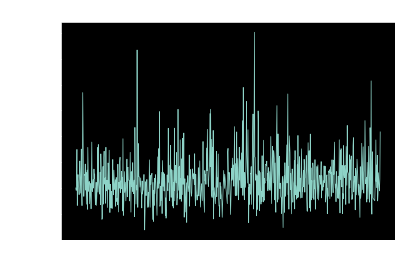

In [19]:
kol_smir_test = {}
for station_id, pvals in m4_p_values.items():
    kol_smir_test[station_id] = st.kstest(pvals, "uniform").statistic

plt.plot(kol_smir_test.keys(), kol_smir_test.values(), linewidth=0.7)
plt.title("Kolmogorov-Smirnov test for all stations for Model 3")
plt.xlabel("Station Id")
plt.ylabel("$D_n$")
plt.savefig("../figures/kol-smir_m3.png")
plt.show()

In [20]:
popularity_dict = {}
for station_id in m4_p_values.keys():
    popularity_dict[station_id] = len(test_bike_data[test_bike_data.start_id == station_id])


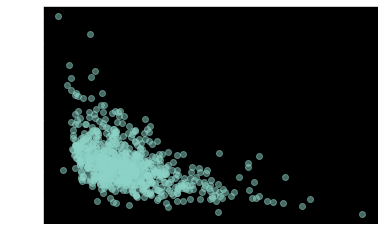

In [21]:
plt.scatter(popularity_dict.values(), kol_smir_test.values(), alpha=0.5)
plt.show()

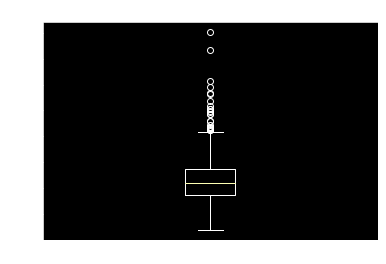

In [22]:
plt.boxplot(kol_smir_test.values())
plt.title("Boxplot of Kolmogorov-Smirnov test statistic for Model 3")
plt.show()

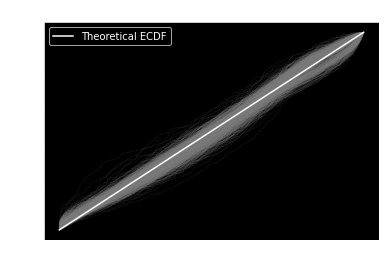

In [23]:
for station, pvals in m4_p_values.items():
    x,y = ecdf(pvals)
    plt.plot(x,y, alpha=0.2, linewidth=0.5, color="gray")

plt.title("ECDF for p-values of Model 4")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], color="white", label="Theoretical ECDF")
plt.legend()
plt.show()

In [32]:
len(m4_p_values[3])

474

In [29]:


pd.DataFrame.from_dict(m4_p_values, orient="index")

,0,1,2,3,4,5,6,7,8,9,...,4352,4353,4354,4355,4356,4357,4358,4359,4360,4361
1,3.110169e-226,0.178030,0.740483,0.427315,0.470397,0.494245,0.739303,0.474243,0.264241,0.104245,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.498305e-51,0.264423,0.491664,0.730459,0.559447,0.305992,0.644635,0.766815,0.551480,0.815830,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.104514e-03,0.729350,0.044869,0.036989,0.188444,0.328876,0.346981,0.531849,0.424849,0.913623,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000000e+00,0.866121,0.070403,0.941311,0.415753,0.641061,0.725298,0.901251,0.441435,0.679316,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5.729671e-60,0.649058,0.118300,0.990327,0.657583,0.246330,0.820590,0.087088,0.468166,0.392953,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,6.560295e-264,0.393216,0.232001,0.047882,0.009304,0.933708,0.556340,0.339619,0.065255,0.140370,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
838,1.599353e-58,0.344229,0.349302,0.116183,0.000310,0.958197,0.247395,0.826581,0.285378,0.710278,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
839,0.000000e+00,0.025645,0.249427,0.219567,0.412691,0.840799,0.722998,0.529644,0.488707,0.919732,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
840,7.787637e-09,0.954094,0.939288,0.749014,0.981471,0.528109,0.009515,0.934117,0.512659,0.709124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
